<a href="https://colab.research.google.com/github/xieruishen/Atari_with_RL/blob/main/Simple_Path_Finding_with_RL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import time
import matplotlib.pyplot as plt
import math

### Macros for Initialization Path Finding Board Configuration

In [2]:
BOARD_ROWS = 15
BOARD_COLS = 15
WIN_STATE = (14, 14) # location of goal
START_STATE = (0, 0)
OBSTACLES = [(1, 4), (2, 3), (2,7), (2, 8), (3, 1), (3, 7), (4,0), (4, 5), (5, 5), 
             (5, 12), (5, 13), (5, 14), (6,5),(6, 6), (9,9), (9, 10), (9, 11), 
             (9, 12), (10, 0), (10, 1), (10, 4), (11, 12), (12, 4), (12, 13), (13, 14)]

### Parameters for Reinforcement Learning

In [3]:
LEARNING_RATE = 0.6
EXPLORE_RATE = 0.4
GAMMA_DECAY = 0.5

### Set Up Board Environment for Path Finding

In [4]:
class BoardState:
    def __init__(self, state=START_STATE, obstacles=OBSTACLES):
        self.board = np.zeros([BOARD_ROWS, BOARD_COLS])
        self.obstacles = obstacles
        # mark obstacles on the board
        for obstacle in obstacles:
          self.board[obstacle[0], obstacle[1]] = -1
        self.board[WIN_STATE[0], WIN_STATE] = 1

        self.state = state # start with starting location
        self.deterministic = False
    
    def checkObstacle(self, state):
        """
          Function to check if a certain location is an obstacle
        """
        return self.board[state[0], state[1]] == -1
        
    def giveReward(self, next_state, cur_state):
        """
          Reward function for going into a given state: R(s,a, s') where s' is the next state
        """
        if next_state == WIN_STATE:
            return 10
        elif self.checkObstacle(next_state):
            return -3
        else:
            # calculate manhattan distance to goal
            next_state_distance = abs(WIN_STATE[0] - next_state[0]) + abs(WIN_STATE[1] - next_state[1])
            cur_state_distance = abs(WIN_STATE[0] - cur_state[0]) + abs(WIN_STATE[1] - cur_state[1])
            if next_state_distance <= cur_state_distance:
              return 3
            else:
              return 2
    
    def checkReachEnd(self):
        return self.state == WIN_STATE

    def _chooseActionProb(self, action):
        other_actions_p = (1 - DETERMINISTIC_Rate)/2
        if action == "up":
            return np.random.choice(["up", "left", "right"], p=[DETERMINISTIC_Rate, other_actions_p, other_actions_p])
        if action == "down":
            return np.random.choice(["down", "left", "right"], p=[DETERMINISTIC_Rate, other_actions_p, other_actions_p])
        if action == "left":
            return np.random.choice(["left", "up", "down"], p=[DETERMINISTIC_Rate, other_actions_p, other_actions_p])
        if action == "right":
            return np.random.choice(["right", "up", "down"], p=[DETERMINISTIC_Rate, other_actions_p, other_actions_p])
    
    def checkAtTopBoundary(self):
        return self.state[0] == 0 
    
    def checkAtBottomBoundary(self):
        return self.state[0] == BOARD_ROWS-1
    
    def checkAtLeftBoundary(self):
        return self.state[1] == 0
    
    def checkAtRightBoundary(self):
        return self.state[1] == BOARD_COLS-1
    
    def checkActionValid(self, action):
        actions_legal = ["up", "down", "left", "right"]
        if self.checkAtTopBoundary():
          actions_legal.remove("up")
        if self.checkAtBottomBoundary():
          actions_legal.remove("down")
        if self.checkAtLeftBoundary():
          actions_legal.remove("left")
        if self.checkAtRightBoundary():
          actions_legal.remove("right")

        if action not in actions_legal:
          action = np.random.choice(actions_legal)
        
        return action
        
    def nextPosition(self, action):
        """
        action: up, down, left, right
        return next position on board
        """
        if action == "up":
            nextState = (self.state[0]-1, self.state[1])
        elif action == "down":
            nextState = (self.state[0]+1, self.state[1])
        elif action == "left":
            nextState = (self.state[0], self.state[1]-1)
        else:
            nextState = (self.state[0], self.state[1]+1)
        return nextState
    
    def printBoard(self):
        # current position
        self.board[START_STATE[0], START_STATE[1]] = 1
        for i in range(0, BOARD_ROWS):
            print('--------------------------------------------------------------')
            out = '| '
            for j in range(0, BOARD_COLS):
                if self.board[i, j] == 1:
                    token = '*'
                elif self.board[i, j] == -1:
                    token = 'x'
                elif self.board[i, j] == 0:
                    token = ' '
                if i == self.state[0] and j == self.state[1]:
                    token = 'p'
                out += token + ' | '
            print(out)
        print('--------------------------------------------------------------')
    
    def printPath(self, path):
        # current position
        self.board[START_STATE[0], START_STATE[1]] = 1
        self.board[WIN_STATE[0], WIN_STATE[1]] = 2
        for i in range(0, BOARD_ROWS):
            print('--------------------------------------------------------------')
            out = '| '
            for j in range(0, BOARD_COLS):
                if self.board[i, j] == 1:
                    token = 'S'
                elif self.board[i, j] == 2:
                    token = 'G'
                elif self.board[i, j] == -1:
                    token = 'x'
                elif self.board[i, j] == 0:
                    token = ' '
                if (i, j) in path:
                    token = 'p'
                out += token + ' | '
            print(out)
        print('--------------------------------------------------------------')
      


### Initialize Board Environment
p: starting position
x: obstacles
*: goal

In [5]:
board = BoardState()
board.printBoard()

--------------------------------------------------------------
| p |   |   |   |   |   |   |   |   |   |   |   |   |   |   | 
--------------------------------------------------------------
|   |   |   |   | x |   |   |   |   |   |   |   |   |   |   | 
--------------------------------------------------------------
|   |   |   | x |   |   |   | x | x |   |   |   |   |   |   | 
--------------------------------------------------------------
|   | x |   |   |   |   |   | x |   |   |   |   |   |   |   | 
--------------------------------------------------------------
| x |   |   |   |   | x |   |   |   |   |   |   |   |   |   | 
--------------------------------------------------------------
|   |   |   |   |   | x |   |   |   |   |   |   | x | x | x | 
--------------------------------------------------------------
|   |   |   |   |   | x | x |   |   |   |   |   |   |   |   | 
--------------------------------------------------------------
|   |   |   |   |   |   |   |   |   |   |   |   |   |  

### Path Finding Agent

In [6]:
class Agent:
    def __init__(self):
        self.states = []  # record all (position, action) taken
        self.states_num_per_round = []
        self.runtime_per_round = []
        self.actions = ["up", "down", "left", "right"]
        self.boardState = BoardState()
        self.reachGoal = self.boardState.checkReachEnd()
        self.lr = LEARNING_RATE
        self.exp_rate = EXPLORE_RATE 
        self.decay_gamma = GAMMA_DECAY

        # initial Q values
        self.Q_values = {}
        for i in range(BOARD_ROWS):
            for j in range(BOARD_COLS):
                self.Q_values[(i, j)] = {}
                for a in self.actions:
                    if (i == 0 and a == "up") or (
                        i == BOARD_ROWS-1 and a == "down") or (
                            j == 0 and a == "left") or (
                                j == BOARD_COLS-1 and a == "right"):
                      self.Q_values[(i, j)][a] = -math.inf
                    else:
                      self.Q_values[(i, j)][a] = 0  
    
    def chooseAction(self):
        # choose action with most expected value/maximum reward
        max_next_reward = 0
        action = ""
        
        if np.random.uniform(0, 1) <= self.exp_rate:
            action = np.random.choice(self.actions)
        else:
            # greedy action
            for a in self.actions:
                current_position = self.boardState.state
                next_reward = self.Q_values[current_position][a]
                if next_reward >= max_next_reward:
                    action = a
                    max_next_reward = next_reward
        action = self.boardState.checkActionValid(action)
        return action
    
    def takeAction(self, action):
        position = self.boardState.nextPosition(action)
        # update State
        self.boardState.state = position     
    
    def reset(self):
        self.states = []
        self.boardState = BoardState()
        self.reachGoal = self.boardState.checkReachEnd()
    
    def play(self, rounds=10):
        i = 0
        start_time = time.time()
        while i < rounds:
            # to the end of game back propagate reward
            print("round: ", i)
            if self.boardState.checkReachEnd():
                # update Q table for end state
                next_optimal_state_qValue = 0
                next_state = WIN_STATE

                # back propagate
                for s in reversed(self.states): # s is a state-action pair
                    current_q_value = self.Q_values[s[0]][s[1]]
                    # update Q value for current state 
                    action_reward = self.boardState.giveReward(next_state, s[0]) # R(s,a,s')
                    # next_state_reward = R(s,a,s') + y*[max_a' Q(s', a')]
                    future_rewards = action_reward + self.decay_gamma*next_optimal_state_qValue 
                    # Q_(k+1)(s,a) = Q_k(s,a) + lr*(next_state_reward - Q_k(s,a)) 
                    updated_q_value = current_q_value + self.lr*(future_rewards - current_q_value)
                    self.Q_values[s[0]][s[1]] = updated_q_value
                    
                    next_state = s[0]
                    next_optimal_state_qValue = updated_q_value

                # reset board and restart another round
                self.states_num_per_round.append(len(self.states))    
                self.reset()
                i += 1
                finish_time = time.time()
                self.runtime_per_round.append(finish_time - start_time) 
                start_time = finish_time
            else:
                action = self.chooseAction()
                # append traces of actions agent has taken
                self.states.append([(self.boardState.state), action])
                print("current position {} action {}".format(self.boardState.state, action))
                #self.boardState.printBoard()
                #print("states: ", self.states)
                # By taking the action, agent reaches the next state
                self.takeAction(action)
                print("next state", self.boardState.state)
                print("*********************************************************")
                self.reachGoal = self.boardState.checkReachEnd()
      
    def get_result_path(self):
        path = []
        current_position = (0,0)
        while current_position != WIN_STATE:
          print("current position: ", current_position)
          path.append(current_position)
          max_next_reward = -math.inf
          action = ""
          for a in self.actions:
              next_reward = self.Q_values[current_position][a]
              if next_reward >= max_next_reward:
                  action = a
                  max_next_reward = next_reward
    
          if action == "up":
              next_position = (current_position[0]-1, current_position[1])
          elif action == "down":
              next_position = (current_position[0]+1, current_position[1])
          elif action == "left":
              next_position = (current_position[0], current_position[1]-1)
          else:
              next_position = (current_position[0], current_position[1]+1)
          current_position = next_position
        return path
      
    def plot_runtime(self):
        plt.plot(self.runtime_per_round)
        plt.ylabel('runtime (seconds)')
        plt.xlabel('round number')
        title = "learning rate: {lr}, gamma decay: {gamma}".format(lr = LEARNING_RATE, gamma = GAMMA_DECAY)
        plt.title(title)
        plt.show()

    def plot_states_num_per_round(self):
        plt.plot(self.states_num_per_round)
        plt.ylabel('number of states taken to reach goal')
        plt.xlabel('round number')
        title = "learning rate: {lr}, gamma decay: {gamma}".format(lr = LEARNING_RATE, gamma = GAMMA_DECAY)
        plt.title(title)
        plt.show()


### Start Path Finding

In [7]:
path_agent = Agent()
path_agent.Q_values

{(0, 0): {'down': 0, 'left': -inf, 'right': 0, 'up': -inf},
 (0, 1): {'down': 0, 'left': 0, 'right': 0, 'up': -inf},
 (0, 2): {'down': 0, 'left': 0, 'right': 0, 'up': -inf},
 (0, 3): {'down': 0, 'left': 0, 'right': 0, 'up': -inf},
 (0, 4): {'down': 0, 'left': 0, 'right': 0, 'up': -inf},
 (0, 5): {'down': 0, 'left': 0, 'right': 0, 'up': -inf},
 (0, 6): {'down': 0, 'left': 0, 'right': 0, 'up': -inf},
 (0, 7): {'down': 0, 'left': 0, 'right': 0, 'up': -inf},
 (0, 8): {'down': 0, 'left': 0, 'right': 0, 'up': -inf},
 (0, 9): {'down': 0, 'left': 0, 'right': 0, 'up': -inf},
 (0, 10): {'down': 0, 'left': 0, 'right': 0, 'up': -inf},
 (0, 11): {'down': 0, 'left': 0, 'right': 0, 'up': -inf},
 (0, 12): {'down': 0, 'left': 0, 'right': 0, 'up': -inf},
 (0, 13): {'down': 0, 'left': 0, 'right': 0, 'up': -inf},
 (0, 14): {'down': 0, 'left': 0, 'right': -inf, 'up': -inf},
 (1, 0): {'down': 0, 'left': -inf, 'right': 0, 'up': 0},
 (1, 1): {'down': 0, 'left': 0, 'right': 0, 'up': 0},
 (1, 2): {'down': 0, 'l

In [8]:
path_agent.play(300)

Streaming output truncated to the last 5000 lines.
current position (6, 10) action right
next state (6, 11)
*********************************************************
round:  283
current position (6, 11) action right
next state (6, 12)
*********************************************************
round:  283
current position (6, 12) action down
next state (7, 12)
*********************************************************
round:  283
current position (7, 12) action up
next state (6, 12)
*********************************************************
round:  283
current position (6, 12) action down
next state (7, 12)
*********************************************************
round:  283
current position (7, 12) action right
next state (7, 13)
*********************************************************
round:  283
current position (7, 13) action left
next state (7, 12)
*********************************************************
round:  283
current position (7, 12) action down
next state (8, 12)
**********

#### Final Q Table after Learning

In [9]:
path_agent.Q_values

{(0, 0): {'down': 5.761724461315501,
  'left': -inf,
  'right': 5.611545700164578,
  'up': -inf},
 (0, 1): {'down': 5.590129516783536,
  'left': 4.918711963759904,
  'right': 5.563215383418943,
  'up': -inf},
 (0, 2): {'down': 5.858506797938513,
  'left': 4.797233911420093,
  'right': 5.337884769176371,
  'up': -inf},
 (0, 3): {'down': 4.458214213406895,
  'left': 4.829784981742641,
  'right': 4.707171565086403,
  'up': -inf},
 (0, 4): {'down': -0.20645295037955405,
  'left': 4.359040081032669,
  'right': 5.931719206591738,
  'up': -inf},
 (0, 5): {'down': 5.753919490123955,
  'left': 4.388146480746764,
  'right': 5.876156050605844,
  'up': -inf},
 (0, 6): {'down': 5.674523556252256,
  'left': 4.597017295340026,
  'right': 5.805875272034567,
  'up': -inf},
 (0, 7): {'down': 4.788422051835729,
  'left': 4.903382146573093,
  'right': 5.831486532266529,
  'up': -inf},
 (0, 8): {'down': 5.57179058840182,
  'left': 4.485148215461928,
  'right': 5.618641669617038,
  'up': -inf},
 (0, 9): {'d

### Result

#### Optimal Path from Q Table

In [10]:
route = path_agent.get_result_path()

current position:  (0, 0)
current position:  (1, 0)
current position:  (1, 1)
current position:  (1, 2)
current position:  (2, 2)
current position:  (3, 2)
current position:  (4, 2)
current position:  (5, 2)
current position:  (5, 3)
current position:  (6, 3)
current position:  (7, 3)
current position:  (7, 4)
current position:  (8, 4)
current position:  (9, 4)
current position:  (9, 5)
current position:  (9, 6)
current position:  (9, 7)
current position:  (10, 7)
current position:  (11, 7)
current position:  (12, 7)
current position:  (12, 8)
current position:  (12, 9)
current position:  (13, 9)
current position:  (14, 9)
current position:  (14, 10)
current position:  (14, 11)
current position:  (14, 12)
current position:  (14, 13)


#### Agenet Learned Path Visualization
p: path
x: obstacles
G: goal

In [11]:
path_agent.boardState.printPath(route)

--------------------------------------------------------------
| p |   |   |   |   |   |   |   |   |   |   |   |   |   |   | 
--------------------------------------------------------------
| p | p | p |   | x |   |   |   |   |   |   |   |   |   |   | 
--------------------------------------------------------------
|   |   | p | x |   |   |   | x | x |   |   |   |   |   |   | 
--------------------------------------------------------------
|   | x | p |   |   |   |   | x |   |   |   |   |   |   |   | 
--------------------------------------------------------------
| x |   | p |   |   | x |   |   |   |   |   |   |   |   |   | 
--------------------------------------------------------------
|   |   | p | p |   | x |   |   |   |   |   |   | x | x | x | 
--------------------------------------------------------------
|   |   |   | p |   | x | x |   |   |   |   |   |   |   |   | 
--------------------------------------------------------------
|   |   |   | p | p |   |   |   |   |   |   |   |   |  

#### Runtime per Round in seconds
The runtime drastically decrease after the first few rounds.

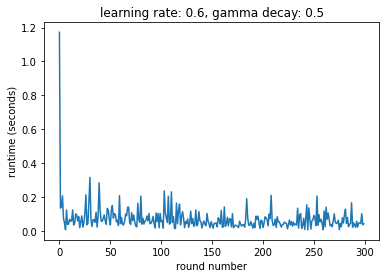

In [12]:
path_agent.plot_runtime()

#### Total Number of Travelled States per Round
Similar as runtime, the total number of states the agenet needs to explore before reaching the goal state drastically decreases after the first few rounds.

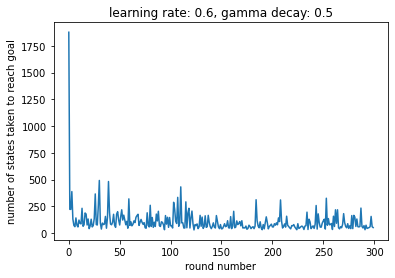

In [13]:
path_agent.plot_states_num_per_round()